# Analyzing Satellite Orbital Data

Fall 2024 CMSC320 - Data Science Project<br>
Pranav Narayan

All contributions credited to me! (Pranav Narayan)

### Introduction

Space is cool! 

I'm an Aerospace Engineering major who also happens to be majoring in Computer Science, and I am very interested in space. I thought, then, it might be a good idea to take some of the skills taught in this class and analyze satellite orbital data, with a specific look at the classification of satellites based solely on their orbits and launch dates. 

Why is this important? As the space environment grows and gets more crowded, easy access for identification of satellites is important. If an astronomer sees an object that appears to be a satellite in orbit for which data is limited, they might want to identify it. If a satellite in space finds another it can't identify immediately, a model such as this could provide predictions and therefore determine appropriate behavior. 

This page aims to do that while providing a tutorial that runs through the entire data science pipeline. It will: <br>
1. Curate the chosen data
2. Perform exploratory data analysis
3. Create a machine learning model
4. Visualize all results
5. Make appropriate conclusions

Fair warning, in advance: If you have access to this notebook, and want to run it, it does take about 10 minutes to run the entire thing. 

The databases used are as follows:

1. Celestrak's Active Satellite Database - https://celestrak.org/NORAD/elements/table.php?GROUP=active&FORMAT=csv
2. The Union of Concerned Scientists (UCS) Satellite Database - https://www.ucsusa.org/resources/satellite-database 

You can (and should!) download them at the links above. 

First, though, we need to import all necessary libraries:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from skyfield.api import load, EarthSatellite
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


pd.set_option('display.max_columns', None) #because truncated outputs help nobody


The libraries do the following: <br>
- pandas: data analysis; allows for manipulation and cleaning of data
- matplotlib and seaborn: visualizations!
- numpy: allows greater and more efficient mathematical capabilities than the base Python
- scipy.stats: allows basic statistical conclusions from data
- skyfield: converts orbital data into more easily usable and visualizable formats
- sklearn: allows for machine learning things, particularly classifiers

### Data Curation

This section will focus on cleaning and prepping the data for analysis - essentially, making sure there's no missing data, adding labels where necessary, changing formats, and things like that. 

The first step is to convert the databases (currently in CSV format) to a pandas dataframe, and inner join them based on satellite NORAD id. This allows us to manipulate the data, and also combines the two databases so we get all the necessary information in one dataframe. 

In [2]:
celestrak = pd.read_csv('celestrak.csv') 
ucs = pd.read_csv('UCS.csv')
db = pd.merge(ucs, celestrak, left_on='NORAD Number', right_on='NORAD_CAT_ID', how="inner").reset_index()
db.columns

Index(['index', 'Name of Satellite, Alternate Names',
       'Current Official Name of Satellite', 'Country/Org of UN Registry',
       'Country of Operator/Owner', 'Operator/Owner', 'Users', 'Purpose',
       'Detailed Purpose', 'Class of Orbit', 'Type of Orbit',
       'Longitude of GEO (degrees)', 'Perigee (km)', 'Apogee (km)',
       'Eccentricity', 'Inclination (degrees)', 'Period (minutes)',
       'Launch Mass (kg.)', ' Dry Mass (kg.) ', 'Power (watts)',
       'Date of Launch', 'Expected Lifetime (yrs.)', 'Contractor',
       'Country of Contractor', 'Launch Site', 'Launch Vehicle',
       'COSPAR Number', 'NORAD Number', 'Comments', 'Unnamed: 28',
       'Source Used for Orbital Data', 'Source', 'Source.1', 'Source.2',
       'Source.3', 'Source.4', 'Source.5', 'Source.6', 'Unnamed: 37',
       'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41',
       'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45',
       'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnam

As a preliminary check, we should look for missing values in the database, so that we don't get errors or problems later on. 

Also, notice that certain columns are useless - for example, NORAD numbers don't provide any useful information, and alternate satellite names are less useful than main names - and/or duplicates, so remove them. 

In [3]:
check = db.copy()
db.drop(columns=["NORAD Number", "Name of Satellite, Alternate Names"], axis=1, inplace=True)

#the "unnamed" columns got added because excel is stupid; the source columns are irrelevant to this analysis
for i in db.columns:
    if "Unnamed" in i or "Source" in i:
        db.drop(i, axis=1, inplace=True)
    elif db[db.isna()[i]][i].size > db[i].size * 0.1:
        db.drop(i, axis=1, inplace=True)

Notice that the ELEMENT_SET_NO column is always 999. This column represents the number of times the data for that satellite has been updated; in this case, it's likely that the data has been updated more than the max the original data's format was capable of holding. Therefore, we can drop this column. Also notice that the CLASSIFICATION_TYPE column always has a value of U; this is because the only satellites whose data we have access to are unclassfied, and none of them will have any other value. Therefore, we can also drop this column. 

In [4]:
db.drop("ELEMENT_SET_NO", axis=1, inplace=True)
db.drop("CLASSIFICATION_TYPE", axis=1, inplace=True)

There are a couple of duplicate columns. Let's drop them. I'm choosing to drop the non-capitalized ones because I know the all-caps ones don't have any missing values. 

In [5]:
db.drop("Eccentricity", axis=1, inplace=True)
db.drop("Inclination (degrees)", axis=1, inplace=True)

Let's convert the strings in the dataframe, where possible, into floats, so we can do math on them:

In [6]:
db["Longitude of GEO (degrees)"] = db["Longitude of GEO (degrees)"].astype(float)
db['Perigee (km)'] = db['Perigee (km)'].str.replace(',', '').astype(float)
db["Perigee (km)"] = db["Perigee (km)"].astype(float)
db['Apogee (km)'] = db['Apogee (km)'].str.replace(',', '').astype(float)
db["Apogee (km)"] = db["Apogee (km)"].astype(float)
db["ECCENTRICITY"] = db["ECCENTRICITY"].astype(float)
db["Period (minutes)"] = db["Period (minutes)"].astype(float)
db['Launch Mass (kg.)'] = db['Launch Mass (kg.)'].str.replace(',', '').astype(float)
db["Launch Mass (kg.)"] = db["Launch Mass (kg.)"].astype(float)
db["Longitude of GEO (degrees)"] = db["Longitude of GEO (degrees)"].astype(float)
db.drop("index", axis=1, inplace=True)

Also, notice the format of the "EPOCH" and "Date of Launch" columns are fairly unusable. Let's try and convert them to be consistent and usable. 

In [7]:
db["EPOCH"] = pd.to_datetime(db["EPOCH"])
db.reset_index() #to make db.loc possible

#because there's at least one term with a '//'
for i in range(db["Date of Launch"].size):
    if "//" in db.loc[i, "Date of Launch"]:
        db.loc[i, "Date of Launch"] = db.loc[i, "Date of Launch"].replace("//", "/")

db["Date of Launch"] = pd.to_datetime(db["Date of Launch"])
db

,Current Official Name of Satellite,Country/Org of UN Registry,Country of Operator/Owner,Operator/Owner,Users,Purpose,Class of Orbit,Type of Orbit,Longitude of GEO (degrees),Perigee (km),Apogee (km),Period (minutes),Launch Mass (kg.),Date of Launch,Contractor,Country of Contractor,Launch Site,Launch Vehicle,COSPAR Number,OBJECT_NAME,OBJECT_ID,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,NORAD_CAT_ID,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT
0,1HOPSAT-TD,NR,USA,Hera Systems,Commercial,Earth Observation,LEO,Non-Polar Inclined,0.0,566.0,576.0,96.08,22.0,2019-12-11,Hera Systems,USA,Satish Dhawan Space Centre,PSLV,2019-089H,IHOPSAT-TD,2019-089H,2024-10-19 02:14:56.531904,15.058365,0.000622,36.9684,77.5033,306.3334,53.6836,0,44859,26644,0.000802,1.180000e-04,0.0
1,AAC AIS-Sat1 (Kelpie 1),United Kingdom,United Kingdom,AAC Clyde Space,Commercial,Earth Observation,LEO,Sun-Synchronous,0.0,637.0,654.0,95.00,4.0,2023-01-03,AAC Clyde Space,Sweden/UK/USA/Netherlands,Cape Canaveral,Falcon 9,2023-001DC,AAC-AIS-SAT1,2023-001DC,2024-10-19 11:01:03.327456,14.826559,0.001215,97.9884,357.5596,106.7616,253.4930,0,55107,8820,0.003110,2.510000e-04,0.0
2,ABS-2,NR,Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,GEO,NaN,75.0,35778.0,35793.0,1436.03,6330.0,2014-02-06,Space Systems/Loral,USA,Guiana Space Center,Ariane 5 ECA,2014-006A,ABS-2,2014-006A,2024-10-19 03:56:42.794880,1.002711,0.000380,0.0039,170.4980,32.4640,319.3043,0,39508,3924,0.000000,-8.800000e-07,0.0
3,ABS-2A,NR,Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,GEO,NaN,-75.0,35700.0,35700.0,1436.10,1800.0,2016-06-15,Boeing Satellite Systems,USA,Cape Canaveral,Falcon 9,2016-038A,ABS-2A (MONGOLSAT-1),2016-038A,2024-10-17 11:55:26.169888,1.002679,0.000194,0.0234,230.6860,304.4061,104.9585,0,41588,3059,0.000000,-8.400000e-07,0.0
4,ABS-3A,NR,Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,GEO,NaN,-3.0,35788.0,35803.0,1436.00,2000.0,2015-03-02,Boeing Satellite Systems,USA,Cape Canaveral,Falcon 9,2015-010A,ABS-3A,2015-010A,2024-10-17 14:59:05.664768,1.002698,0.000156,0.0125,148.8460,7.5155,92.0253,0,40424,3528,0.000000,-2.800000e-07,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6253,Ziyuan 1-02C,China,China,China Centre for Resources Satellite Data and ...,Government,Earth Observation,LEO,Sun-Synchronous,0.0,763.0,773.0,100.20,1500.0,2011-12-22,China Academy of Space Technology (CAST),China,Taiyuan Launch Center,Long March 4B,2011-079A,ZIYUAN 1-02C (ZY 1-02C),2011-079A,2024-10-19 11:02:24.000000,14.372148,0.000575,98.4850,0.2098,325.3552,229.2097,0,38038,67221,0.000844,2.470000e-05,0.0
6254,Ziyuan 1-2D,NR,China,China Centre for Resources Satellite Data and ...,Government,Earth Observation,LEO,Sun-Synchronous,0.0,748.0,758.0,99.80,2650.0,2019-09-14,China Academy of Space Technology (CAST),China,Taiyuan Launch Center,Long March 4B,2019-059A,ZY-1 02D,2019-059A,2024-10-19 11:16:40.994688,14.353926,0.000252,98.3983,2.7047,118.5783,241.5657,0,44528,26744,0.000409,1.130000e-05,0.0
6255,Ziyuan 3,China,China,China Centre for Resources Satellite Data and ...,Government,Earth Observation,LEO,Sun-Synchronous,0.0,500.0,504.0,94.70,2650.0,2012-01-09,China Academy of Space Technology (CAST),China,Taiyuan Launch Center,Long March 4B,2012-001A,ZIYUAN 3-1 (ZY 3-1),2012-001A,2024-10-19 09:13:54.837408,15.387869,0.000520,97.2292,353.0399,71.8107,288.3705,0,38046,70998,0.001730,6.680000e-04,0.0
6256,Ziyuan 3-2,China,China,China Centre for Resources Satellite Data and ...,Government,Earth Observation,LEO,Sun-Synchronous,0.0,487.0,500.0,94.49,2630.0,2016-05-29,China Academy of Space Technology (CAST),China,Taiyuan Launch Center,Long March 4B,2016-033A,ZIYUAN 3-2 (ZY 3-2),2016-033A,2024-10-19 09:44:57.837408,15.211881,0.000751,97.4454,7.4891,211.1241,148.9551,0,41556,46588,0.001310,2.930000e-04

### Exploratory Data Analysis and Visualization

This section is where we learn about our data. What information does it contain? Does anything seem odd or important? What can we learn from it? Are there any patterns or correlations relevant to our desired conclusions?<br>

There are a few things that I've noticed in the dataset that I'd like to take a look at, but you can do anything you want, too. 

##### Second Derivative of Mean Motion - Hypothesis Testing

Looking at the dataframe above, it's notable that very few rows seem to have nonzero entries in the MEAN_MOTION_DDOT column, which represents the second derivative of the mean motion of each satellite, divided by 6. 

If that sounds like complicated math, it's really not - mean motion is just the average angular speed of the satellite in orbit. Its first derivative is how that changes - for example, solar wind could be a cause of deceleration, which would provide nonzero first derivative of mean motion. Its second derivative is the change in the first derivative - for example, is the solar wind getting stronger? The storage of this value divided by 6 is just convention. 

Let's, first, change each value to just simply be the second derivative of mean motion, and then find out what percent actually has a value in this column:

In [8]:
db["MEAN_MOTION_DDOT"] *= 6
repr(db[abs(db['MEAN_MOTION_DDOT']) != 0].size / db.size * 100) + \
"% - percent of satellites with the second derivative of mean motion not equal to 0"

'0.3515500159795462% - percent of satellites with the second derivative of mean motion not equal to 0'

The second derivative of mean motion is usually zero, and only nonzero in cases of significant significant perturbation or atmospheric drag - the solar wind example above isn't a common scenario. In theory, then, it would primarily affect satellites of low altitude, where the atmosphere is significantly more prevalent. To test that, it seems fairly reasonable to use Perigee (km) (the closest point in the orbit to the Earth) as a stand-in for altitude in this check, as that's where atmospheric drag will have the strongest impact. Updating the database, then, and splitting it into nonzero and zero distributions:

In [9]:
#splitting the database into two, satellites with nonzero and zero second derivative of mean motion
db.dropna(subset="Perigee (km)", inplace=True)
nonzero = db[abs(db['MEAN_MOTION_DDOT']) != 0].reset_index().drop(columns=['index'])
zero = db[abs(db["MEAN_MOTION_DDOT"]) == 0].reset_index().drop(columns=["index"])

Setting up a hypothesis test comes next. A hypothesis test is a statistical model that allows us to determine the accuracy of our assumptions, and learn something about our data. There are two hypotheses - guesses - involved: a Null Hypothesis and an Alternative Hypothesis. The Null Hypothesis is the pre-analysis assumption; the Alternative Hypothesis is its opposite. The test we perform will give us the probability that the Null Hypothesis is true, given the data available; it does this through a p-value and significance level. The p-value is that probability, and the significance level is set by us: if the p-value is less than the significance level, you reject the Null Hypothesis. We will use a significance level of α = 0.05, which is fairly standard. 

Let's set that up:

<b>Null Hypothesis</b> - The Perigee (km) distribution of satellites with nonzero second derivative of mean motion is not lower than the Perigee (km) distribution of satellites with zero second derivative of mean motion. 

<b>Alternative Hypothesis</b> - The Perigee (km) distribution of satellites with nonzero second derivative of mean motion is lower than the Perigee (km) distribution of satellites with zero second derivative of mean motion. 

The type of data and the nature of the hypotheses are important to this process. Since the guess is that a lower altitude will lead to nonzero second derivative of mean motion, this is a <b>one-tailed</b> test - the lower tail. This means we only care about data that clusters around the lower end of the distribution; a two-tailed test would care about the upper end, as well. 

Also, since the data for the nonzero group is indepenent of the zero group - there is no explicit relationship between the groups - and, unfortunately, not likely to be normally distributed - the sample size is only 36, barely meeting that criteria, and satellites tend to cluster around certain orbits instead of being randomly placed - this calls for a nonparametric hypothesis test. Parametric tests are relevant if the data is normally distributed, which is typically assumed above a sample size of 30, and assumptions can be made of related data. I'm choosing to use the <b>Mann-Whitney U</b> test, but there are other nonparametric tests that have different characteristics and are well-suited for different applications. 

This test can be performed using the scipy.stats library, which has several built-in hypothesis tests that we can just call. 

In [10]:
_, p = stats.mannwhitneyu(nonzero['Perigee (km)'], zero['Perigee (km)'], alternative='less')
print("p-value: %.10E" % p)

p-value: 6.4461023785E-05


Now, the p-value is clearly very small, indicating that the null hypothesis should be rejected; our theory is therefore accepted!

Let's plot this, now. Visualizations are an important part of data science, as they allow you (and anyone else) to more intuitively understand the conclusions you draw. We will use the MatPlotLib and Seaborn libraries, Python's primary plotting libraries, to visualize all our data. 

Because of the extreme range of satellite orbits that exist, we have to modify some of the data to make the visualizations palatable. We remove the outliers - there are some satellites so far out that they render a large chunk of the closer ones invisible, and they don't really contribute to our question anyway. 

The visualization I've chosen to use is a violin plot, which allows us to see the distribution of satellites in each category. 

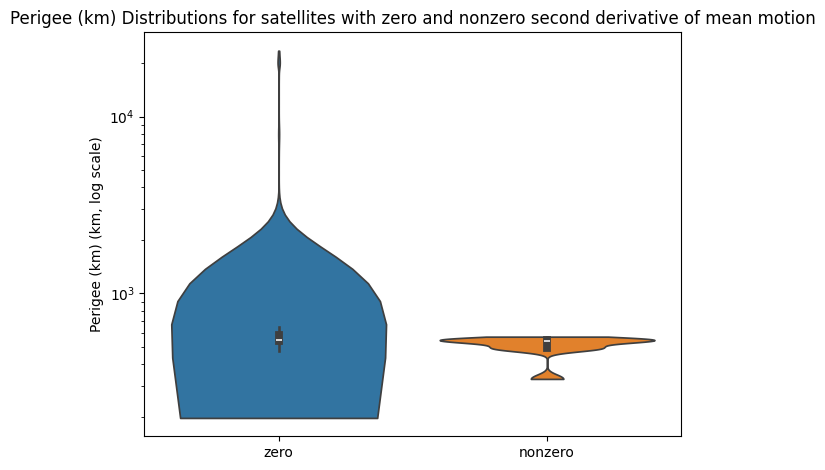

In [11]:
#cut out outliers to actually make the plots visible
top = zero["Perigee (km)"].std() * 2 + zero["Perigee (km)"].mean()
bottom = zero["Perigee (km)"].std() * -2 + zero["Perigee (km)"].mean()

#add relevant data to new dataframe
hm = pd.DataFrame()
hm['zero'] = zero[~zero['Perigee (km)'].isna() & (zero['Perigee (km)'] < top) & (zero['Perigee (km)'] > bottom)]['Perigee (km)']
hm['nonzero'] = nonzero[~ (nonzero['Perigee (km)'].isna())]['Perigee (km)']

#plot!
ax = sns.violinplot( data=hm, cut=0, bw_method=0.3)
ax.set_ylabel("Perigee (km) (km, log scale)")
ax.set_title("Perigee (km) Distributions for satellites with zero and nonzero second derivative of mean motion")
plt.tight_layout()
plt.yscale("log") #to make the ridiculous scales of space visible on a tiny screen
plt.show()

Note that the y-axis used is a log scale, as the distance values of satellites far away are exponentially higher than those in Low Earth Orbit. 

Notice the differences between the two distributions: the satellites in the nonzero group clearly don't have altitudes as high as those in the zero group. It's visual proof of the hypothesis testing result!

##### Grouping Satellite Orbits by Purpose

Alright, now back to the original data. Let's group the dataframe by the "Purpose" Column, for fun. 

In [12]:
grouped = db.groupby("Purpose").describe()
grouped

Longitude of GEO (degrees)  \
                                                                    count   
Purpose                                                                     
Communications                                                     5001.0   
Communications/Maritime Tracking                                      5.0   
Communications/Navigation                                             1.0   
Communications/Technology Development                                 4.0   
Earth Observation                                                   710.0   
Earth Observation                                                     3.0   
Earth Observation/Communications                                      2.0   
Earth Observation/Communications/Space Science                        1.0   
Earth Observation/Earth Science                                       1.0   
Earth Observation/Navigation                                          9.0   
Earth Observation/Space Science                                       1.0   
Earth Observation/Technology Development                              4.0   
Earth Science                                                        17.0   
Earth Science/Earth Observation                                       1.0   
Earth/Space Observation                                               1.0   
Meteorological                                                        6.0   
Mission Extension Technology                                          2.0   
Navigation/Global Positioning                                       133.0   
Navigation/Regional Positioning                                      12.0   
Platform                                                              1.0   
Satellite Positioning                                                 1.0   
Space Observation                                                     3.0   
Space Science                                                        73.0   
Space Science/Technology Demonstration                                1.0   
Surveillance                                                         18.0   
Technology Demonstration                                             46.0   
Technology Development                                              193.0   
Technology Development/Educational                                    2.0   

                                                                           \
                                                      mean    min     25%   
Purpose                                                                     
Communications                                    1.154917 -179.8   0.000   
Communications/Maritime Tracking                  0.000000    0.0   0.000   
Communications/Navigation                        55.000000   55.0  55.000   
Communications/Technology Development             6.250000    0.0   0.000   
Earth Observation                                 1.382648 -159.6   0.000   
Earth Observation                                 0.000000    0.0   0.000   
Earth Observation/Communications                 64.000000    0.0  32.000   
Earth Observation/Communications/Space Science    0.000000    0.0   0.000   
Earth Observation/Earth Science                   0.000000    0.0   0.000   
Earth Observation/Navigation                      0.000000    0.0   0.000   
Earth Observation/Space Science                   0.000000    0.0   0.000   
Earth Observation/Technology Development          0.000000    0.0   0.000   
Earth Science                                     0.000000    0.0   0.000   
Earth Science/Earth Observation                   0.000000    0.0   0.000   
Earth/Space Observation                           0.000000    0.0   0.000   
Meteorological                                    0.000000    0.0   0.000   
Mission Extension Technology                    165.750000  -27.5  69.125   
Navigation/Global Positioning                    15.873759    0.0   0.000   
Navigation/Regional Positioning           

Notice that there are many satellites that seem to fall into multiple categories. As an approximation, let's just assume the first category listed is the category of the satellite - this gets too complicated otherwise. Also, let's combine and rename a couple categories: 

Technology Demonstration and Technology Development as: Technology Development. <br>
Space Science and Space Observation as: Space Science. <br>
Satellite Positioning as Navigation. <br>
Earth as Earth Observation. 

All of this can be done with pandas. 

In [13]:
db.reset_index(inplace=True)
#renaming
for i in range(db["Purpose"].size):
    if "/" in db.loc[i, "Purpose"]:
        hm = db.loc[i, "Purpose"]
        index = hm.index("/")
        db.loc[i, "Purpose"] = hm[:index]
    if db.loc[i, "Purpose"] == "Technology Demonstration":
        db.loc[i, "Purpose"] = "Technology Development"
    if db.loc[i, "Purpose"] == "Space Observation":
        db.loc[i, "Purpose"] = "Space Science"
    if db.loc[i, "Purpose"] == "Satellite Positioning":
        db.loc[i, "Purpose"] = "Navigation"
    if db.loc[i, "Purpose"] == "Earth" or "Earth Observation" in db.loc[i, "Purpose"]:
        #second part of the conditional is because there appears to be duplicate categories otherwise
        #and i can't figure out the difference between them
        db.loc[i, "Purpose"] = "Earth Observation"
grouped = db.groupby("Purpose").describe()
grouped

index                                        \
                               count         mean     min      25%     50%   
Purpose                                                                      
Communications                5012.0  3411.843575     2.0  2243.75  3496.5   
Earth Observation              732.0  2139.479508     0.0   533.75  1041.5   
Earth Science                   18.0   873.222222   212.0   414.75   576.5   
Meteorological                   6.0  5976.500000  5974.0  5975.25  5976.5   
Mission Extension Technology     2.0  1126.500000  1126.0  1126.25  1126.5   
Navigation                     146.0   659.602740   122.0   158.25   519.5   
Platform                         1.0   466.000000   466.0   466.00   466.0   
Space Science                   77.0  2143.662338    44.0   750.00  1254.0   
Surveillance                    18.0   732.666667   701.0   705.25   709.5   
Technology Development         241.0  2403.489627    12.0   724.00  1951.0   

                                                            \
                                  75%     max          std   
Purpose                                                      
Communications                4749.25  6241.0  1585.469917   
Earth Observation             2143.25  6257.0  2282.306976   
Earth Science                  639.75  6223.0  1355.863847   
Meteorological                5977.75  5979.0     1.870829   
Mission Extension Technology  1126.75  1127.0     0.707107   
Navigation                    1158.75  6094.0   638.473098   
Platform                       466.00   466.0          NaN   
Space Science                 2099.00  6225.0  2037.709322   
Surveillance                   713.75  1135.0   100.528603   
Technology Development        2175.00  6226.0  2157.124682   

                             Longitude of GEO (degrees)                     \
                                                  count        mean    min   
Purpose                                                                      
Communications                                   5011.0    1.168577 -179.8   
Earth Observation                                 732.0    1.515956 -159.6   
Earth Science                                      18.0    0.000000    0.0   
Meteorological                                      6.0    0.000000    0.0   
Mission Extension Technology                        2.0  165.750000  -27.5   
Navigation                                        146.0   22.435205    0.0   
Platform                                            1.0    0.000000    0.0   
Space Science                                      77.0   -1.324675 -102.0   
Surveillance                                       18.0    0.000000    0.0   
Technology Development                            241.0    4.540041  -65.5   

                                                                          \
                                 25%     50%      75%    max         std   
Purpose                                                                    
Communications                 0.000    0.00    0.000  180.0   26.736994   
Earth Observation              0.000    0.00    0.000  165.9   24.324973   
Earth Science                  0.000    0.00    0.000    0.0    0.000000   
Meteorological                 0.000    0.00    0.000    0.0    0.000000   
Mission Extension Technology  69.125  165.75  262.375  359.0  273.296771   
Navigation                     0.000    0.00    0.000  160.0   45.620629   
Platform                       0.000    0.00    0.000    0.0         NaN   
Space Science                  0.000    0.00    0.000    0.0   11.623979   
Surveillance                   0.000    0.00    0.000    0.0    0.000000   
Technology Development         0.000    0.00    0.000  162.9   23.420939   

                             Perigee (km)                                   \
                                    count          mean      min       25%   
Purpose                                          

Some of the categories are still fairly small and fairly niche. Let's try and combine them with others:

Add Platform to Space Science. <br>
Add Mission Extension Technology to Technology Development. <br>
Add Surveillance, Meterological, and Earth Science to Earth Observation. <br>

In [14]:
db.drop("index", axis=1, inplace=True)
db.reset_index(inplace=True)
#renaming
for i in range(db["Purpose"].size):
    if db.loc[i, "Purpose"] == "Mission Extension Technology":
        db.loc[i, "Purpose"] = "Technology Development"
    if db.loc[i, "Purpose"] == "Platform":
        db.loc[i, "Purpose"] = "Space Science"
    if db.loc[i, "Purpose"] in ["Surveillance", "Meteorological", "Earth Science"]:
        db.loc[i, "Purpose"] = "Earth Observation"
grouped = db.groupby("Purpose")
grouped.describe()

index                                                \
                         count         mean    min      25%     50%      75%   
Purpose                                                                        
Communications          5012.0  3407.127893    2.0  2238.75  3491.5  4744.25   
Earth Observation        774.0  2103.952196    0.0   539.25  1013.5  2134.75   
Navigation               146.0   657.890411  122.0   158.25   519.5  1153.75   
Space Science             78.0  2118.500000   44.0   732.50  1248.5  2089.50   
Technology Development   243.0  2389.296296   12.0   723.50  1943.0  2168.50   

                                            Longitude of GEO (degrees)  \
                           max          std                      count   
Purpose                                                                  
Communications          6236.0  1584.926419                     5011.0   
Earth Observation       6252.0  2270.877182                      774.0   
Navigation              6089.0   636.884195                      146.0   
Space Science           6220.0  2032.157179                       78.0   
Technology Development  6221.0  2150.010610                      243.0   

                                                                           \
                             mean    min  25%  50%  75%    max        std   
Purpose                                                                     
Communications           1.168577 -179.8  0.0  0.0  0.0  180.0  26.736994   
Earth Observation        1.433695 -159.6  0.0  0.0  0.0  165.9  23.657407   
Navigation              22.435205    0.0  0.0  0.0  0.0  160.0  45.620629   
Space Science           -1.307692 -102.0  0.0  0.0  0.0    0.0  11.549226   
Technology Development   5.866872  -65.5  0.0  0.0  0.0  359.0  32.644486   

                       Perigee (km)                                          \
                              count          mean    min       25%      50%   
Purpose                                                                       
Communications               5012.0   3634.601157  198.0    538.00    548.0   
Earth Observation             774.0   2253.830749  241.0    517.00    571.0   
Navigation                    146.0  23942.335616  523.0  20149.25  21515.5   
Space Science                  78.0   2050.384615  258.0    534.50    587.5   
Technology Development        243.0   3086.950617  240.0    515.00    572.0   

                                                       Apogee (km)  \
                             75%      max          std       count   
Purpose                                                              
Communications            580.00  37782.0  9837.557540      5012.0   
Earth Observation         690.00  35897.0  7404.583464       774.0   
Navigation              23457.25  35796.0  6514.550165       146.0   
Space Science             682.00  35779.0  5409.685480        78.0   
Technology Development    686.50  36097.0  8999.874603       243.0   

                                                                         \
                                mean    min      25%      50%       75%   
Purpose                                                                   
Communications           3769.099561  280.0    541.0    561.0    600.00   
Earth Observation        2563.785530   49.0    535.0    591.5    703.75   
Navigation              24359.246575  536.0  20215.0  21561.0  23570.25   
Space Science           21544.525641  422.0    569.5    632.5    800.00   
Technology Development   3548.230453  460.0    545.5    601.0    790.00   

                                               Period (minutes)              \
                             max           std            count        mean   
Purpose                                                                       
Communications          353798.0  11140.557074           5007.0  211.197695   
Earth Observation        39754.0   8070.232320            757.0

Now that we have 5 decently sized groups, let's find a way to visualize this. 

Because it's cool, I'm going to try and plot the mean orbit of each category. 

Some basic orbital mechanics, first. There are 6 orbital elements by which all orbits can be uniquely characterized: 

Inclination (in degrees) <br>
Mean Motion (in revolutions per day) <br>
Right Ascension of the Ascending Node (in degrees)<br>
Eccentricity<br>
Argument of Pericenter / Perigee (in degrees)<br>
Mean Anomaly (in degrees)<br>

Ignore what each means, it doesn't matter. Also important is the TLE (two-line element) format. Celestrak's primary data storage is actually in TLEs, but they also have CSVs, which is what I've chosen to use. But TLEs are two-line objects that contain all the important information about a satellite and its orbit. They're important because the Skyfield library, which I'm going to use to generate time-varying orbital positions, takes TLEs as inputs. 

The Skyfield library allows for easy manipulation of orbital elements. Once I've used pandas to take the average orbit of each grouping, I can input them into a TLE format to easily create satellite objects that have that mean orbit, even though none of the actual satellites do! 

The plotting is done via MatPlotLib's 3D plotting abilities. Note that in the below visualization, the blue dot at the center represents the Earth (not to scale!). 

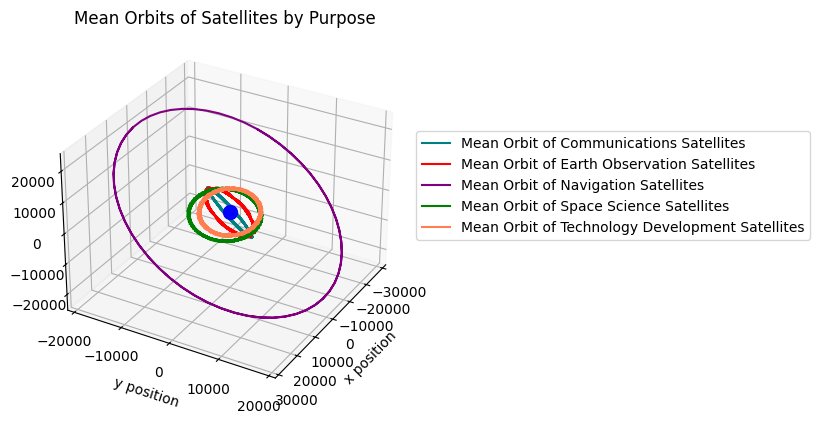

In [15]:
ts = load.timescale() #set time=0
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
grouped = db.groupby(by="Purpose")
colors = ['coral', 'green', 'purple', 'red', 'teal'] #colors for the orbits (kind of aesthetic?)
#loop through the different purpose categories
for name, data in grouped:
    #calculate means per category of all orbital elements
    mean_inclination = data["INCLINATION"].mean()
    mean_motion = data["MEAN_MOTION"].mean()
    mean_raan = data["RA_OF_ASC_NODE"].mean()
    mean_ecc = data["ECCENTRICITY"].mean()
    mean_arg_perigee = data["ARG_OF_PERICENTER"].mean()
    mean_anomaly = data["MEAN_ANOMALY"].mean()

    #create the TLE
    tle_line_1 = f"1 00000U 00000AAA 21265.73525694 +.00002124  +00000-0  +50000-4 0 9995"
    tle_line_2 = f"2 00000 {mean_inclination:8.4f} {mean_raan:8.4f} {(mean_ecc*10**7):07.0f} {mean_arg_perigee:8.4f} {mean_anomaly:8.4f} {mean_motion:11.8f} 00000 "
    checksum = 0
    for i in tle_line_2:
        if not i == " " and not i == ".":
            checksum += int(i)
    tle_line_2 += str(checksum % 10)
    
    #Use Skyfield to create a satellite object
    satellite = EarthSatellite(tle_line_1, tle_line_2, f"Mean Orbit for category {name}", ts)

    #generate time-varying position, and add to plot
    t = ts.utc(2024, 10, np.arange(0, 1, 0.01))
    geocentric = satellite.at(t)
    x, y, z = geocentric.position.km
    ax.plot(x, y, z, label=f"Mean Orbit of {name} Satellites", color=colors.pop())

ax.legend(loc='upper left', bbox_to_anchor=(1, 0.75))
ax.view_init(elev=30, azim=30) #change viewpoint to make all orbits visible-ish
ax.scatter(0, 0, 0, s=100, color='blue') #create the Earth, not to scale
plt.xlabel("x position")
plt.ylabel("y position")
plt.title("Mean Orbits of Satellites by Purpose")
plt.show()

The conclusion here is the following: 

1. We can, fairly easily, classify all active major satellites into 5 categories. <br>
2. The orbits for each category can vary greatly, just purely by visual examination. 

Cool. Now back to the original dataset. 

##### Date of Launch and Launch Mass - Correlations


Another interesting column could be the "Date of Launch" Column. Let's look at some summary statistics for it; pandas is nice enough to do that for us. 

In [16]:
db["Date of Launch"].describe()

count                             6253
mean     2020-02-20 07:58:18.672636928
min                1974-11-15 00:00:00
25%                2020-03-18 00:00:00
50%                2021-07-01 00:00:00
75%                2022-08-12 00:00:00
max                2023-04-27 00:00:00
Name: Date of Launch, dtype: object

Based on that, it appears that a vast majority of the satellites in the UCS database were launched during and post-COVID, which is interesting in and of itself. We can, and should, go farther, though. 

It might be interesting to see if the year of launch has any correlation with a technological characteristic, such as launch mass. We can use scipy.stats, again, to see correlations and p-values. In this case, the hypotheses are simple - they aren't correlated, or they are. We will also get a correlation coefficient, which goes from -1 to 1 - a negative value indicates that the fields have opposite behaviors, a zero value indicates exactly 0 correlation, and a positive value indicates related behaviors. The larger the magnitude of the correlation coefficient, the higher the relationship between each field's behavior. 

In [17]:
db["Year of Launch"] = db["Date of Launch"].dt.year
years = db[~db["Year of Launch"].isna()]["Year of Launch"].sort_index() #sorts shouldn't have any impact as they'll keep their indices from the dataframe
mass = db[~db["Launch Mass (kg.)"].isna()]["Launch Mass (kg.)"].sort_index()
correlation, p = stats.pearsonr(years[:min(years.size, mass.size)], mass[:min(years.size, mass.size)]) #used this instead of db.corr() because it gives a p-value
print(f"Correlation Coefficient: {correlation}; p-value: {p}")

Correlation Coefficient: -0.30320998729280546; p-value: 2.1232059721016904e-129


There is! The p-value, which in this case represents the possibility of an uncorrelated relationship given the data, is extremely low, which indicates a correlation of some significance. And here, the correlation doesn't seem to be particularly strong, but it is unmistakably a slight negative correlation. 

This seems to indicate that as time progresses, lighter and lighter satellites get launched. And that makes sense, as as launching these satellites gets cheaper, lighter satellites are actually worth launching!

Let's plot this relationship, once again using seaborn, but this time as a plot with a regression line:

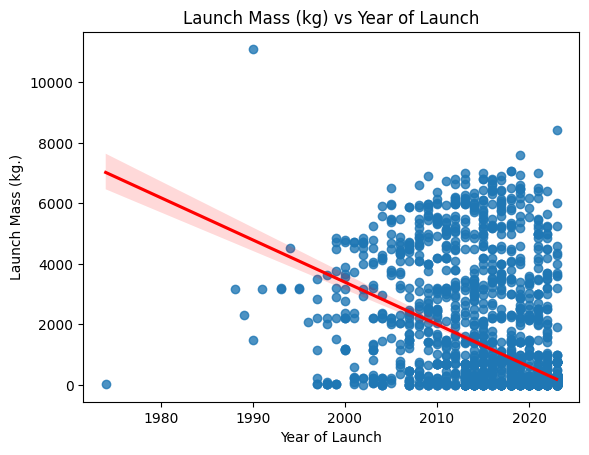

In [18]:
sns.regplot(data=db, x="Year of Launch", y="Launch Mass (kg.)", line_kws={"color":"red"})
plt.title("Launch Mass (kg) vs Year of Launch")
plt.show()

It's clearly not a particularly visible correlation, but if the math says it's there, I guess it's there. 



That should be three conclusions, then; let's move on to some machine learning. If you'd like to learn more about the dataset, there's so much more analysis that can be done; you should do it!

### Primary Analysis - Machine Learning

Considering we already grouped the satellites by purpose, it may be interesting to see if we can make a model that, given a satellite's orbital elements, can predict its category. 

First, let's make a new dataframe with only the necessary prediction features, and another with the purposes. You'll notice that I've included all the orbital elements except Mean Anomaly - that's because Mean Anomaly represents the portion of the orbit completed at the time of observation, which only depends on the time of observation, and therefore doesn't really help categorize orbits. 

In [19]:
X = db.drop(columns=["Current Official Name of Satellite", "Country/Org of UN Registry", "EPHEMERIS_TYPE", "Period (minutes)", \
                     "Country of Operator/Owner", "Operator/Owner", "Users", "Purpose", "Class of Orbit", "Launch Mass (kg.)", "MEAN_ANOMALY", \
                        "Type of Orbit", "Contractor", "Country of Contractor", "Launch Site", "Date of Launch", "Longitude of GEO (degrees)", \
                            "Launch Vehicle", "COSPAR Number", "OBJECT_NAME", "OBJECT_ID", "EPOCH", "index", "Perigee (km)", "Apogee (km)", \
                                "NORAD_CAT_ID", "REV_AT_EPOCH", "BSTAR", "MEAN_MOTION_DOT", "MEAN_MOTION_DDOT", "Year of Launch"], axis=1)
y = db["Purpose"]

To be able to verify our model, we need to test it on previously unseen data. To do this, we split the data into training and testing datasets; typically, about 80% of the data is used to train the model, and 20% to test it, so that's what we'll do. 

Also, we're going to normalize our training data - this scales all the data to be within similar ranges. Since orbital elements can vary wildly in magnitude, this makes sure those extremely large values don't have an outsize impact on the model's fitting mechanisms. And note that I've chosen to oversample the dataset - if I didn't the Communications satellites would overpower the rest, so we need to even the odds a little bit. 

In [20]:
test_size = 0.2

#
balancer = SMOTE()
X_balanced, y_balanced = balancer.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=test_size)
X_train_scaled = StandardScaler().fit_transform(X_train, y_train)
X_test_scaled = StandardScaler().fit_transform(X_test, y_test)

This is a classification problem - given a set of data and categories into which each sample fits, which category will a given sample fit into? 

One the most popular classification models is Random Forest. Random Forest runs the data through a series of decision trees fit by the training data, and uses their outputs to classify the new data. Many other classification models exist, but I like Random Forest, so let's use that. Luckily, the sklearn module provides this model for us; all we have to do is train it!

In [21]:
forest = RandomForestClassifier()

We want to make sure this data trains and performs evenly across all parts of the training data. To do this, we'll use a method called k-fold cross-validation. Essentially, we take the training data, split it into k sections, and cycle through using k-1 at a time to train, and 1 to test. This allows us to make sure the model is evenly trained across all the data, as well as check its generalizability across different randomly selected portions. 

Luckily, sk-learn does this for us, too!

In [22]:
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True)

accuracy = cross_val_score(forest, X_train_scaled, y_train, cv=skf, scoring='accuracy')
print(f"Cross Validation Accuracy for Random Forest: \n\tmean = {np.mean(accuracy)}\n\tstd = {np.std(accuracy)}")


Cross Validation Accuracy for Random Forest: 
	mean = 0.9729646947734182
	std = 0.0022140272456895064


That accuracy looks pretty good! And the standard deviation, too, is fairly small! So it seems the data should generalize pretty well. Now let's try to optimize some of the model's hyperparameters. 

The relevant hyperparameters are: 

- n_estimators: number of decision trees in the forest
- max_depth: max depth of each tree; prevents overfitting
- min_samples_split: prevents splitting of nodes when not really necessary
- min_samples_leaf: samples required at a leaf node
- max_features: # of features to consider at each split
- criterion: how splits are decided

There are a lot of hyperparameters. To do this, we'll use an sklearn module called RandomizedSearchCV - it'll run a random selection of these parameter options, and pick the setting with the highest cross-validation accuracy. I'll run it several times, to make sure we get the best possible version; you'll only see the final output, though. 

In [23]:
estimator_forest = RandomForestClassifier()
parameters_forest = {
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=250, num=10)],
    'max_depth': [None] + [10, 15, 20],
    'min_samples_split': [2, 4, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'log_loss'],
}

random_CV_forest = RandomizedSearchCV(estimator_forest, parameters_forest, cv=5, n_iter=20, scoring='accuracy', verbose=2, n_jobs=-1)
random_CV_forest.fit(X_train_scaled, y_train)

print(f"Best Parameters: {random_CV_forest.best_params_}")
print(f"Best Cross-Validation Accuracy: {random_CV_forest.best_score_}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 183, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'log_loss'}
Best Cross-Validation Accuracy: 0.9717679112271703


Alright, so there doesn't seem to have been much optimizing necessary there - you can see from that the accuracy didn't really improve much, and many of the hyperparameters didn't seem to have an optimal setting. Either way, I'm going to use the following setup, based both on the visible quantities and the patterns I noticed:

- n_estimators: 200
- min_samples_split: 2
- min_samples_leaf: 1
- max_depth: None
- criterion: log_loss

Now, let's reinitialize the model with the necessary hyperparameters, and rerun the k-fold cross-validation. 

In [24]:
forest = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_depth=None, criterion='log_loss')

k_folds = 5
skf = StratifiedKFold(n_splits=k_folds)

accuracy = cross_val_score(forest, X_train_scaled, y_train, cv=skf, scoring='accuracy')
print(f"Cross Validation Accuracy for Random Forest: \n\tmean = {np.mean(accuracy)}\n\tstd = {np.std(accuracy)}")

Cross Validation Accuracy for Random Forest: 
	mean = 0.9740124495446343
	std = 0.0012344225842812414


Slight improvements, at least!

Now, let's actually fit this model to our training data, and use the testing data to test it. 

In [25]:
forest.fit(X_train_scaled, y_train)

y_pred_forest = forest.predict(X_test_scaled)

forest_accuracy = accuracy_score(y_test, y_pred_forest)
print(f"Accuracy of Random Forest: {forest_accuracy:.2f}")
forest_report = classification_report(y_test, y_pred_forest)
print(f"Random Forest classification report: \n{forest_report}")

Accuracy of Random Forest: 0.63
Random Forest classification report: 
                        precision    recall  f1-score   support

        Communications       0.78      0.08      0.15       995
     Earth Observation       0.48      0.81      0.60       992
            Navigation       0.99      0.87      0.93       963
         Space Science       0.65      0.70      0.68      1040
Technology Development       0.57      0.71      0.63      1022

              accuracy                           0.63      5012
             macro avg       0.69      0.63      0.60      5012
          weighted avg       0.69      0.63      0.60      5012



That is... not very accurate, unfortunately. That's clear enough from simply the accuracy, but the rest of the numbers are important, too:

- Precision: what percentage of the samples placed in this category actually belonged in this category?
- Recall: what percentage of the samples that actually belonged in this category were correctly placed in this category?
- F1-score: a balance between precision and recall, calculated as follows:
$$ F1 score = 2 * \frac{precision * recall}{precision + recall} $$
- Support: the number of samples that actually belong to this category
    - You'll notice that the support values are fairly even; this is because of the balancing we did earlier via SMOTE

Now that you know what each metric means, let's look at the report again. It's plain to see that some categories were better able to be classified than others: navigation had really high values, for example, while communication had very _very_ low values.  

I tend to think the F1-score is the best metric for evaluation, especially since we don't have a use-case that relies on either precision or recall more than the other. And that's not a great value, averaged. 

This can probably be explained by the fact that this is very complex data. Satellite purposes aren't explicitly dependent on their orbit. You can see this fact in the visualization above - many of the categories' orbits are clustered fairly close together. They are, however, implicitly dependent on their orbit, and that's why we get some success: navigation satellites, for example, tend to be pretty far out in Geostationary orbits, so they can continually monitor the same section of the Earth. But it's clearly an imperfect science, and may be difficult to classify with traditional, simple classification methods. 

Let's try and make a visualization of the above results. 

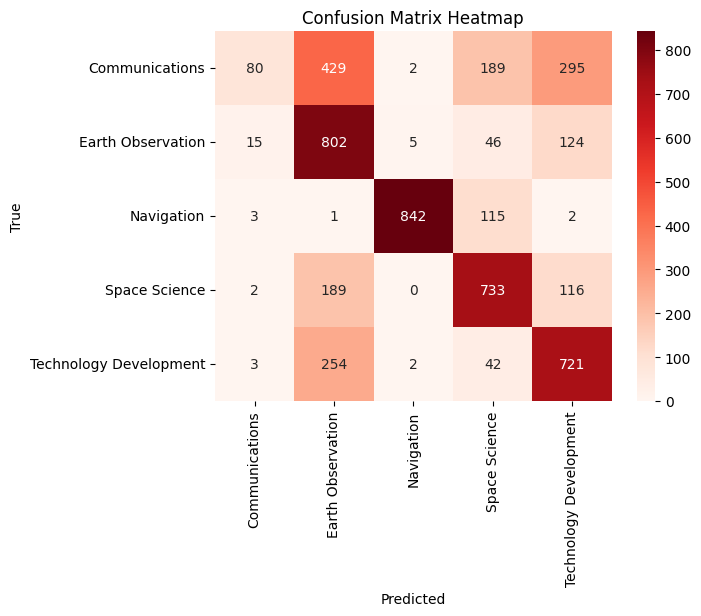

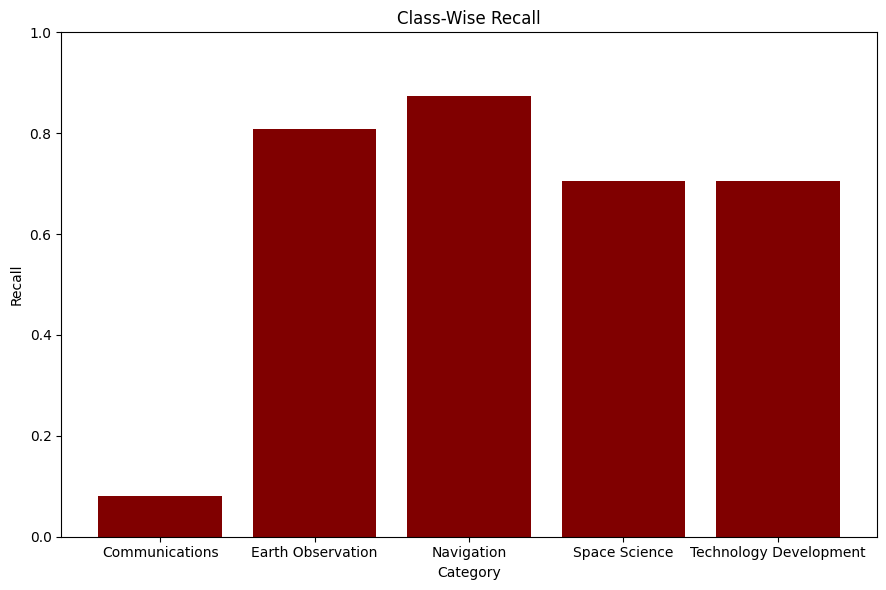

In [26]:
cm = confusion_matrix(y_test, y_pred_forest)
classes = ["Communications", "Earth Observation", "Navigation", "Space Science", "Technology Development"]

plt.figure(0)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")

plt.figure(1, figsize=(9, 6))
class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.bar(classes, class_wise_accuracy, color="maroon")
plt.xlabel("Category")
plt.ylabel("Recall")
plt.title("Class-Wise Recall")
plt.xticks(classes)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

The first visualization above is a Confusion Matrix. It's not that confusing. On the y-axis are the true categories, and the x axis has the predictions. A given square (x, y) the number of entries predicted in x that are in category y. Ideally, the values on the diagonal would be the only nonzero values. Clearly, that's far from the case. We can see the abysmal performance of the model on Communications satellites very clearly here. Apparently, our Random Forest model can't tell the difference between Communications and Earth Observation satellites very well. On the other hand, it does do fairly well with Navigation satellites. 

The second visualization above is a bar chart for class-wise recall; it simply plots the recall of each class. I just think it's funny to see that Communications satellites are so far below the rest. 

Alright, clearly Random Forest can't capture the behavior of our model that well. What might be able to, then?

Let's try using a Neural Network instead, for fun. This requires a whole new set of imports, visible below; they're all from the PyTorch library, which is a common library used for Neural Networks. Each are important in the construction and optimization of our NN. 

In [27]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

Neural Networks can't really handle non-numerical data, unfortunately. Fortunately, for a classification problem, there's an easy solution: One-Hot Encoding. Essentially, this involves making each category into its own column, and giving each sample a 1 in the column of the category to which it belongs. Not too difficult to do, but it's even easier because - wait for it - sklearn does it for us!

Unfortunately, it does mean we have to go through the splitting and scaling of the data again. This time, we also load the data into tensor datasets, which are then converted to data loaders, from which the PyTorch library's built in NNs accept data. The first important hyperparameter appears here: batch size. How many samples do we give the Neural Network at once? 32 is a widely used batch size, and from my extensive testing, appears to perform best, so we'll use that. 

In [28]:
X_nn = db.drop(columns=["Current Official Name of Satellite", "Country/Org of UN Registry", "EPHEMERIS_TYPE", "Period (minutes)", \
                     "Country of Operator/Owner", "Operator/Owner", "Users", "Purpose", "Class of Orbit", "Launch Mass (kg.)", "MEAN_ANOMALY", \
                        "Type of Orbit", "Contractor", "Country of Contractor", "Launch Site", "Date of Launch", "Longitude of GEO (degrees)", \
                            "Launch Vehicle", "COSPAR Number", "OBJECT_NAME", "OBJECT_ID", "EPOCH", "index", "Perigee (km)", "Apogee (km)", \
                                "NORAD_CAT_ID", "REV_AT_EPOCH", "BSTAR", "MEAN_MOTION_DOT", "MEAN_MOTION_DDOT", "Year of Launch"], axis=1)
y_nn = pd.DataFrame(db["Purpose"])

ohe = OneHotEncoder(sparse_output=False).fit(y_nn)
y_nn = ohe.transform(y_nn)

test_size = 0.2
balancer = SMOTE()
X_balanced_nn, y_balanced_nn = balancer.fit_resample(X_nn, y_nn)

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_balanced_nn, y_balanced_nn, test_size=test_size)
X_train_scaled_nn = StandardScaler().fit_transform(X_train_nn)
X_test_scaled_nn = StandardScaler().fit_transform(X_test_nn)


training_data = TensorDataset(torch.tensor(X_train_scaled_nn, dtype=torch.float32), torch.tensor(np.array(y_train_nn), dtype=torch.float32))
testing_data = TensorDataset(torch.tensor(X_test_scaled_nn, dtype=torch.float32), torch.tensor(np.array(y_test_nn), dtype=torch.float32))

train_loader = DataLoader(training_data, batch_size=32)
test_loader = DataLoader(testing_data, batch_size=32)

Now to build the Neural Network itself. This inherits from the PyTorch library, and is fairly simple to make; for our purposes, we use a series of linear layers, with the input layer accepting the input shape, the hidden layers having varying sizes to increase computation power, and the output layer returning a list with the same number of elements as categories we're trying to classify. Each entry in that list is the probability of the category corresponding to its index being the correct category. 

I've chosen the number of layers, as well as each layer's width, based on my own iterative testing; there's almost definitely a more optimal configuration, though, so you should definitely try and find it! 

There are a couple more important factors here: the activation function and batch normalization. I've chosen the activation function LeakyReLU. When the input is positive, this function is linear with a slope of 1 and a y-intercept that is very small. When the input is negative, this function is 0. This allows for some nonlinearization of the data while maintaining simplicity. The Leaky version modifies the regular version by making the y-intercept nonzero; this is important for us because we have a lot of zeroes in the target output, and that could result in zeroing out our gradients - we don't want that. 

Batch normalization is a way of optimizing the values generated by a hidden layer; it normalizes them to a normal distribution, which mitigates fluctuations in the activation function's outputs. This stabilizes our gradients, and ultimately decreases model loss. 

In [29]:
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(5, 8)
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 8)
        self.fc7 = nn.Linear(8, 5)
        self.bn = nn.BatchNorm1d(16)

    def forward(self, x):
        leaky = nn.ReLU()
        x = leaky(self.fc1(x))
        x = leaky(self.fc2(x))
        x = leaky(self.bn(self.fc3(x)))
        x = leaky(self.fc4(x))
        x = leaky(self.fc5(x))
        x = leaky(self.fc6(x))
        return self.fc7(x)

Now for the training loop. A couple important factors here: the loss function, the optimizer, and the scheduler. 

The loss function I've chosen - BCEWithLogitsLoss - is compatible with our matrix-format target data; it applies the sigmoid activation function to all outputs, which leads to the probabilities I mentioned above (each element is a logit). Another common loss function for classification problems is CrossEntropyLoss, but that requires flattening of our matrix, and this seemed more elegant. 

The optimizer I've chosen is just the most popular - Adam. The learning rate, however, is important: I chose this after several testing iterations. There may be a better one, but this worked fairly well. Smaller learning rates tend to cause the loss to plateau sooner, while larger learning rates never really consistently drop the loss over several epochs. 

The scheduler is a way to actively control the learning rate - it checks the loss every epoch, and if it senses a failure to drop the loss significantly across a couple epochs, it drops the learning rate. The parameters of the scheduler also required considerable tuning, and you should definitely try to improve it yourself! There's an exactly 0% chance this is the optimal solution. 

The loop itself is a simple Neural Network loop: calculate the forward pass, find the loss, do a backwards pass, update the scheduler, repeat. The number of epochs is also, by the way, a result of considerable tuning. 

In [42]:
model = MLPModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.25, threshold=0.001)
epochs = 20
losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step(loss.item())
    losses.append(loss.item())
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, LR: {scheduler.optimizer.param_groups[0]['lr']}')

print('Finished Training')

Epoch 1/20, Loss: 0.28070276975631714, LR: 0.01
Epoch 2/20, Loss: 0.24323603510856628, LR: 0.01
Epoch 3/20, Loss: 0.2280675172805786, LR: 0.01
Epoch 4/20, Loss: 0.26900121569633484, LR: 0.01
Epoch 5/20, Loss: 0.26117557287216187, LR: 0.0025
Epoch 6/20, Loss: 0.24347886443138123, LR: 0.0025
Epoch 7/20, Loss: 0.23934035003185272, LR: 0.000625
Epoch 8/20, Loss: 0.23027446866035461, LR: 0.000625
Epoch 9/20, Loss: 0.22967760264873505, LR: 0.00015625
Epoch 10/20, Loss: 0.2265876829624176, LR: 0.00015625
Epoch 11/20, Loss: 0.22615468502044678, LR: 0.00015625
Epoch 12/20, Loss: 0.22533997893333435, LR: 0.00015625
Epoch 13/20, Loss: 0.22495412826538086, LR: 0.00015625
Epoch 14/20, Loss: 0.224256232380867, LR: 0.00015625
Epoch 15/20, Loss: 0.22371163964271545, LR: 0.00015625
Epoch 16/20, Loss: 0.2234956920146942, LR: 0.00015625
Epoch 17/20, Loss: 0.2233983278274536, LR: 0.00015625
Epoch 18/20, Loss: 0.222968190908432, LR: 0.00015625
Epoch 19/20, Loss: 0.22246146202087402, LR: 0.00015625
Epoch 20

Let's visualize the loss as a function of epochs. 

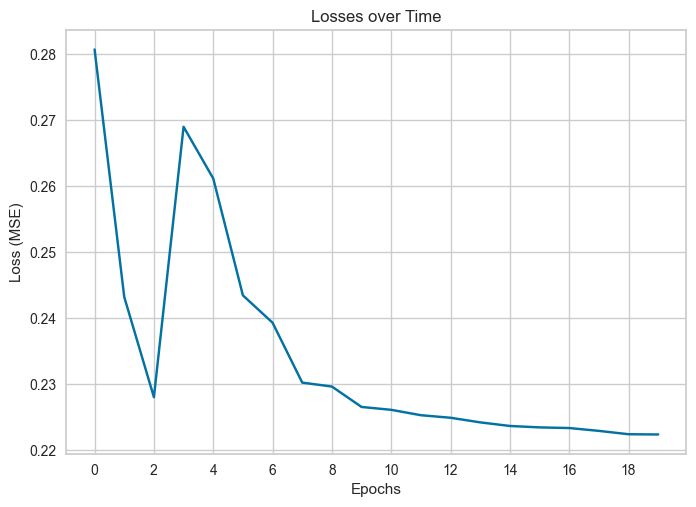

In [43]:
plt.plot(losses)
plt.title("Losses over Time")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.xticks(np.arange(0, epochs, 2))
plt.show()

As you can see, the loss dropped pretty sharply at the beginning, and then began to plateau, which is typically a sign that more epochs won't improve your loss, and you should stop. There are ways to actively monitor this during the training; I didn't feel they were necessary, as my iterative tuning worked pretty well.  

Now, let's check our accuracy on an unseen test dataset - this is the metric that actually matters. Let's hope this is good!

In [44]:
correct = 0
total = 0
model.eval()
for inputs, labels in test_loader:
    outputs = model(inputs)
    total += labels.size(0)
    correct += (torch.argmax(outputs, 1) == torch.argmax(labels, 1)).count_nonzero()

accuracy = correct / total
print(f'Accuracy on test set: {accuracy * 100:.2f}%')

Accuracy on test set: 74.28%


Hey, better than the Random Forest, at least! If not by much. Let's try and visualize this result again. Instead of a confusion matrix, though, let's use an ROC curve. The ROC curve plots the True Positive rate against the False Positive rate. It's an indication of how accurate a model is able to be. I'm also going to include an Area Under Curve calculation for each category; this summarizes the findings of the ROC curve in one number. 

A good ROC curve hugs the top right corner, while a completely random ROC curve follows the line y = x. Similarly, a perfect AUC is 1.0. 

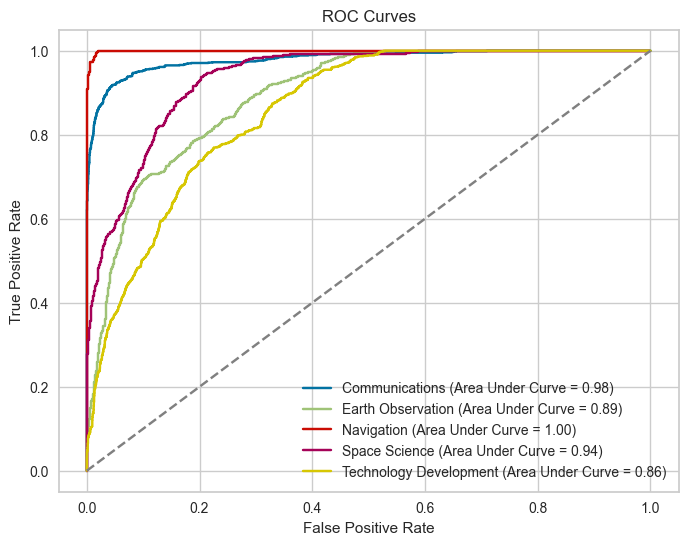

In [45]:

y_true_nn = []
y_prob = []
soft = nn.Softmax(1)
for inputs, labels in test_loader:
    outputs = model(inputs)
    y_true_nn.extend(labels.numpy())
    y_prob.extend(soft(outputs).detach().numpy())
classes_nn = [0, 1, 2, 3, 4]
y_true_nn = np.array(y_true_nn)
y_bin = label_binarize(y_true_nn, classes=classes_nn)
plt.figure(figsize=(8, 6))
for i, label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], np.array(y_prob)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (Area Under Curve = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color="grey", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.show()


You'll notice that, as with Random Forest, the Navigation satellites seem easiest to classify, while Technology Development being the most difficult is new. Interesting. This one actually does pretty well with Communications satellites. 

I also want to plot a precision-recall curve, which is exactly what it sounds like. 

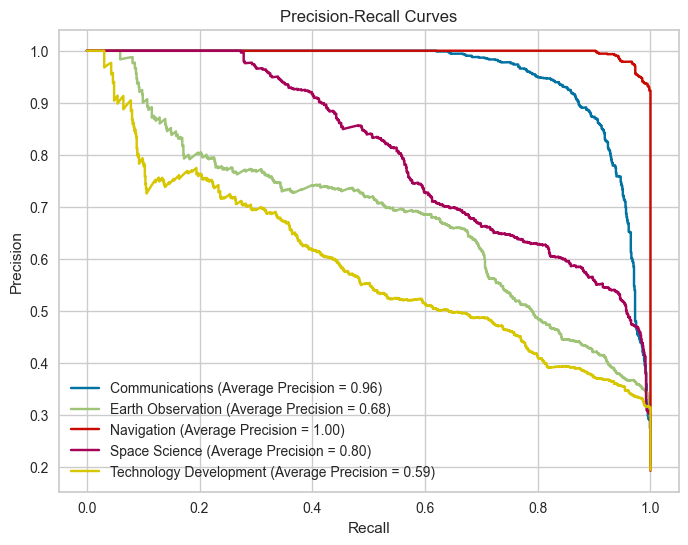

In [46]:


plt.figure(figsize=(8, 6))
for i, label in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_bin[:, i], np.array(y_prob)[:, i])
    avg_precision = average_precision_score(y_bin[:, i], np.array(y_prob)[:, i])
    plt.plot(recall, precision, label=f"{label} (Average Precision = {avg_precision:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(loc="lower left")
plt.show()


Essentially the same findings, just in a different format. I'll present conclusions later, but this is interesting. 

Now, out of curiosity, I want to test an unsupervised clustering model on this data. Essentially, that means I'm going to ask a model to look at the data, with no answers, and figure out the best way to cluster it into groups. I'll use K-Means Clustering, because it's simple. 

It's also important to note the use of Principal Component Analysis. While I'm using the same 5 orbital elements as above, it's hard to visualize 5 dimensions, and also hard for K-Means to compute them effectively. PCA combines those 5 features into, in our case, 3 that explain most of the variance in the dataset. 

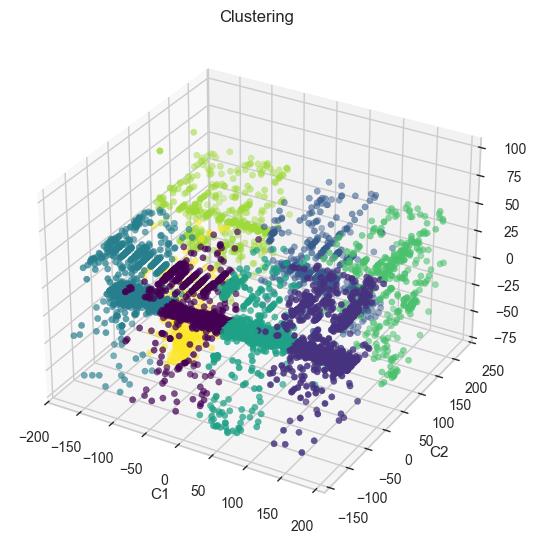

In [47]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

X_cluster = db.drop(columns=["Current Official Name of Satellite", "Country/Org of UN Registry", "EPHEMERIS_TYPE", "Period (minutes)", \
                     "Country of Operator/Owner", "Operator/Owner", "Users", "Purpose", "Class of Orbit", "Launch Mass (kg.)", "MEAN_ANOMALY", \
                        "Type of Orbit", "Contractor", "Country of Contractor", "Launch Site", "Date of Launch", "Longitude of GEO (degrees)", \
                            "Launch Vehicle", "COSPAR Number", "OBJECT_NAME", "OBJECT_ID", "EPOCH", "index", "Perigee (km)", "Apogee (km)", \
                                "NORAD_CAT_ID", "REV_AT_EPOCH", "BSTAR", "MEAN_MOTION_DOT", "MEAN_MOTION_DDOT", "Year of Launch"], axis=1)

X_scaled_cluster = np.array(X_cluster)#StandardScaler().fit_transform(X_cluster)

kmeans = KMeans()
pca = PCA(3)

X_pca = pca.fit_transform(X_scaled_cluster)

labels=kmeans.fit_predict(X_pca)

fig = plt.figure(13)
ax = fig.add_subplot(projection='3d', label="C3")
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='viridis')

plt.xlabel('C1')
plt.ylabel('C2')
plt.title('Clustering')
plt.tight_layout()
plt.show()


That's kinda messy, no?

Let's see if we can optimize this like we did Random Forest. We'll use two methods - the elbow method and silhouette visualizers. These will be imported from the yellowbrick library. 

The elbow method fits a model for many values of k - as in the number of clusters - and plots the curve of distortion (similar to loss) vs k. It selects the "elbow" of that curve as the optimal k-value, since going with a larger k, at that point, is less efficient. 

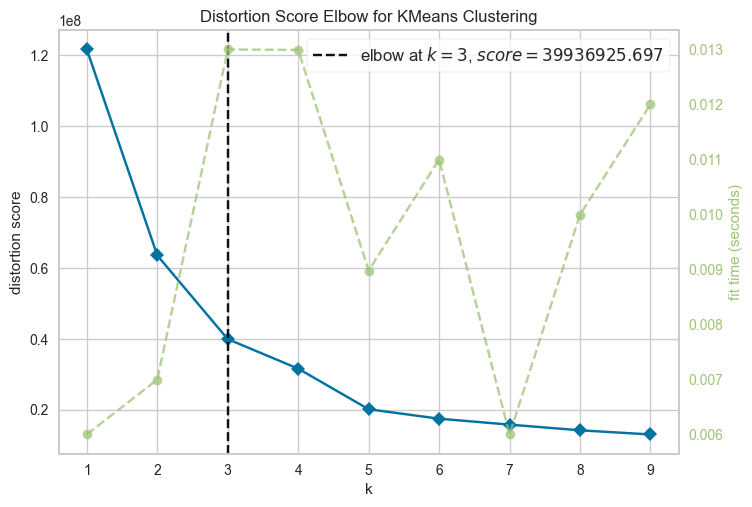

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

kmeans = KMeans()
viz = KElbowVisualizer(kmeans, k=range(1, 10))

viz.fit(X_pca)
viz.show()

Looks like the elbow method suggests k = 3. Let's validate that with the silhouette visualizer. 

This visualizer does the same iterative steps as the elbow method, but allows us to see relative cluster size and density - in the average silhouette score. This is important because we want clusters of relatively equal size and high density, if possible. 

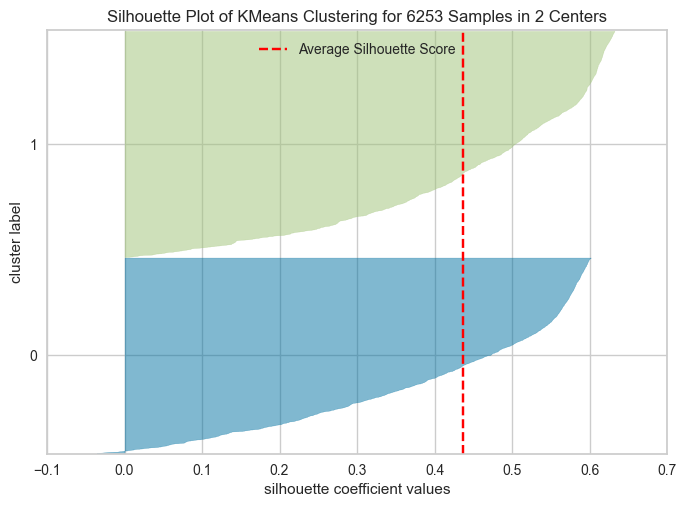

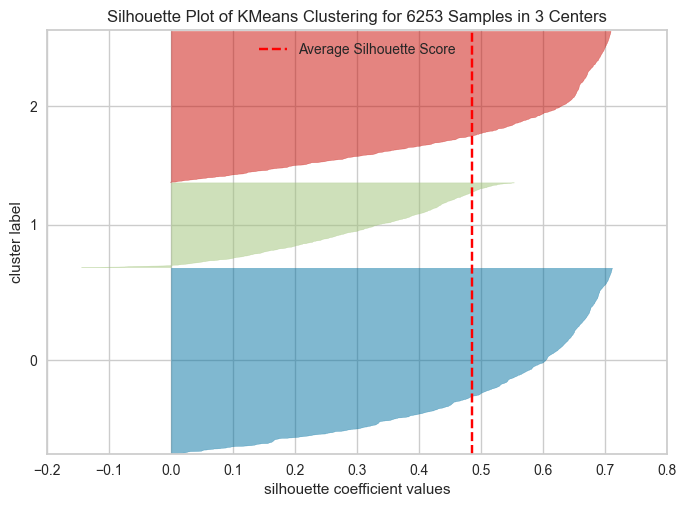

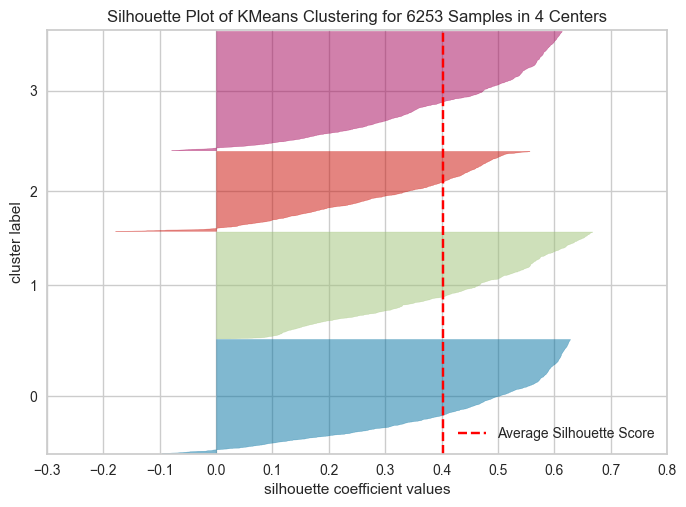

In [49]:
for k in range(2, 5):
    kmeans = KMeans(k)

    sil = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    sil.fit(X_pca)
    sil.show()

Based on this, it seems once again that k=3 is optimal. It has one of the highest average silhouette scores, and increasing k over that is just inefficient. 

Let's retry the clustering with k = 3. 

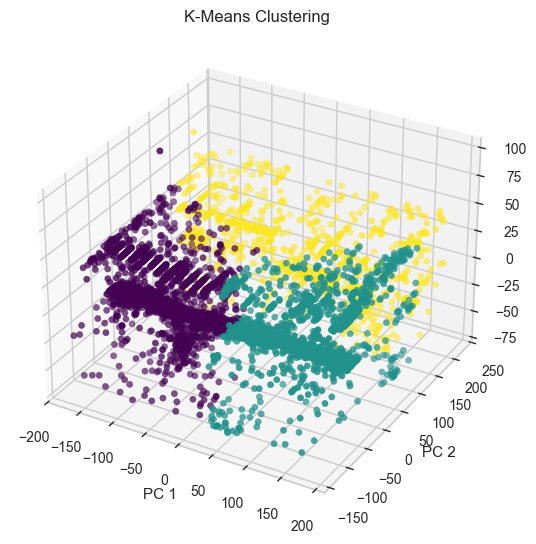

In [50]:
kmeans = KMeans(3)


labels=kmeans.fit_predict(X_pca)

fig = plt.figure(13)
ax = fig.add_subplot(projection='3d', label="PC 3")
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='viridis')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('K-Means Clustering')
plt.tight_layout()
plt.show()

Hey, those groups are pretty good, now! 

I'm also curious to see which features contributed most to our Principal Components, so I'm going to make a dataframe to visualize that. The below is the PCA's component matrix; each feature's value in each component is the portion of the variance represented by that feature in that component. 

In [51]:
df = {"Mean Motion": pca.components_[:, 0], "Eccentricity": pca.components_[:, 1], "Inclination": pca.components_[:, 2], \
      "RA of Ascending Node": pca.components_[:, 3], "Argument of Perigee": pca.components_[:, 4]}
component_matrix = pd.DataFrame(df)
component_matrix

,Mean Motion,Eccentricity,Inclination,RA of Ascending Node,Argument of Perigee
0,0.002853,-0.000011,0.009219,0.999947,0.003698
1,-0.010835,0.000044,-0.039858,-0.003297,0.999141
2,0.091065,0.000016,0.994969,-0.009583,0.040648


Apparently, the three angular features - Inclination, RA of Ascending Node, and Argument of Perigee - were the most important. Interesting!

### Conclusions

Now that we've finished our attempts at machine learning analyses, let's see what we figured out. 

1. Navigation satellites are easily separable from other satellites, likely due to their tendency to be located further away from Earth. 
2. We can see, in satellite orbits, the growth in the space sector, and the increasing accesibility of space - smaller, more frequent launches are happening. 
3. Satellite identification, without proper documentation or uniquely identifying characteristics, is difficult! Multiple machine learning models failed to accurately predict categories at 80+ percent accuracy. 
4. Satellite orbits may represent complex decisions behind placements, but there are still clusters around which satellites tend to be found. Additionally, these clusters tend to depend less on orbital distance and more on the angles around the Earth at which their orbits are inclined and rotated. This is also visible in the orbital visualization, where 4/5 categories are close to the Earth, but at different angles. 

I think that covers the main points. 

To figure this out, we had to process the given data, look for connections between different features, visualize these features, analyze the differentiability of these features, and visualize that. Even after all the preparation, our models were nowhere near perfect - while successful, they could certainly be optimized. 

This highlights the complexity of the space ecosystem as it stands today, and the issues facing space-based awareness and sensing. The information collected here could be used as a basis for more complicated studies that enhance policy and engineering decisions made to simplify access and operability in space. 

A more complicated study might, for example, engage in more sophisticated dimensionality reduction to maximize the information available to our model. Or it might focus on designing policies mandated on all spacecraft that allow maximum information gain when sensed by an observer in space or on Earth. There are a lot of potential avenues to enhance the classification and identification of satellites without too much knowledge, and it is an important field for the future of our space ecosystem. 

For now, I'm pretty happy with what I've been able to display here, with limited time, resources, and expertise. 

### Additional Resources

##### Orbital Mechanics

The only real resources for this are textbooks and courses. But you can find some overviews online: 

https://spsweb.fltops.jpl.nasa.gov/portaldataops/mpg/MPG_Docs/MPG%20Book/Release/Chapter7-OrbitalMechanics.pdf<br>
https://www.youtube.com/watch?v=bcvnfQlz1x4 

Also, the data used in this project is useful to try and visualize some of these concepts; the datasets are linked in the intro. 

##### Space Domain Awareness and Debris Mitigation

These are currently very important topics in the space ecosystem. In fact, there are multiple professors at UMD doing research on topics directly related or adjacent to some of the concepts in this field. 

https://www.csis.org/analysis/future-space-domain-awareness-needs-national-security-space <br>
https://www.japcc.org/essays/the-role-of-space-domain-awareness/ <br>
https://www.spacefoundation.org/space_brief/space-situational-awareness/ <br> 
https://www.unoosa.org/pdf/publications/st_space_49E.pdf <br>
https://fas.org/publication/how-do-you-clean-up-170-million-pieces-of-space-junk/ <br>

##### Data Exploration and Visualization

https://www.geeksforgeeks.org/what-is-data-exploration-and-its-process/ <br>
https://datavizcatalogue.com/ <br>
https://www.statsig.com/blog/hypothesis-testing-explained <br>

##### Machine Learning Classification

https://www.datacamp.com/blog/classification-machine-learning <br>
https://www.geeksforgeeks.org/getting-started-with-classification/ <br>

##### Unsupervised Learning

https://www.ibm.com/topics/unsupervised-learning <br>
